In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from mixture_gaussian import data_generator

In [3]:
if torch.cuda.is_available():
    cuda = True
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"
else:
    cuda = False

In [4]:
dset = data_generator()

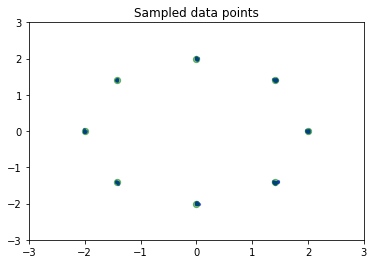

In [5]:
def plot(points, title):

    plt.scatter(points[:, 0], points[:, 1], s=5, c='b', alpha=0.5)
    plt.scatter(dset.centers[:, 0], dset.centers[:, 1], s=40, c='g', alpha=0.5)
    plt.title(title)
    plt.ylim(-3, 3)
    plt.xlim(-3, 3)
    plt.show()
    plt.close()
    
sample_points = dset.sample(100)
plot(sample_points, 'Sampled data points')

In [18]:
# Model params
z_dim = 256
g_inp = z_dim
g_hid = 128
g_out = dset.size

d_inp = g_out
d_hid = 128
d_out = 1

minibatch_size = 512

unrolled_steps = 5
d_learning_rate = 1e-3
g_learning_rate = 1e-3
optim_betas = (0.5, 0.999)
num_iterations = 30000
log_interval = 1000
save_interval = 2000
d_steps = 1  
g_steps = 1

In [19]:
def noise_sampler(N, z_dim):
    return np.random.uniform(size=[N, z_dim]).astype('float32')

In [20]:
###### MODELS: Generator model and discriminator model
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.tanh(self.map1(x))
        x = F.tanh(self.map2(x))
        return self.map3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.tanh(self.map1(x))
        x = F.tanh(self.map2(x))
        return F.sigmoid(self.map3(x))

In [21]:
G = Generator(input_size=g_inp, hidden_size=g_hid, output_size=g_out)
D = Discriminator(input_size=d_inp, hidden_size=d_hid, output_size=d_out)
if cuda:
    G = G.cuda()
    D = D.cuda()
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

In [22]:
def d_loop():
    # 1. Train D on real+fake
    d_optimizer.zero_grad()

    #  1A: Train D on real
    d_real_data = torch.from_numpy(dset.sample(minibatch_size))
    if cuda:
        d_real_data = d_real_data.cuda()
    d_real_decision = D(d_real_data)
    target = torch.ones_like(d_real_decision)
    if cuda:
        target = target.cuda()
    d_real_error = criterion(d_real_decision, target)  # ones = true

    #  1B: Train D on fake
    d_gen_input = torch.from_numpy(noise_sampler(minibatch_size, g_inp))
    if cuda:
        d_gen_input = d_gen_input.cuda()
    with torch.no_grad():
        d_fake_data = G(d_gen_input)
    d_fake_decision = D(d_fake_data)
    target = torch.zeros_like(d_fake_decision)
    if cuda:
        target = target.cuda()
    d_fake_error = criterion(d_fake_decision, target)  # zeros = fake
    
    d_loss = d_real_error + d_fake_error
    d_loss.backward()
    d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
    return d_real_error.cpu().item(), d_fake_error.cpu().item()

In [23]:
def d_unrolled_loop(d_gen_input=None):
    # 1. Train D on real+fake
    d_optimizer.zero_grad()

    #  1A: Train D on real
    d_real_data = torch.from_numpy(dset.sample(minibatch_size))
    if cuda:
        d_real_data = d_real_data.cuda()
    d_real_decision = D(d_real_data)
    target = torch.ones_like(d_real_decision)
    if cuda:
        target = target.cuda()
    d_real_error = criterion(d_real_decision, target)  # ones = true

    #  1B: Train D on fake
    if d_gen_input is None:
        d_gen_input = torch.from_numpy(noise_sampler(minibatch_size, g_inp))
    if cuda:
        d_gen_input = d_gen_input.cuda()
    
    d_fake_data = G(d_gen_input)
    d_fake_decision = D(d_fake_data)
    target = torch.zeros_like(d_fake_decision)
    if cuda:
        target = target.cuda()
    d_fake_error = criterion(d_fake_decision, target)  # zeros = fake
    
    d_loss = d_real_error + d_fake_error
    d_loss.backward(create_graph=True)
    d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
    return d_real_error.cpu().item(), d_fake_error.cpu().item()

In [32]:
def d_param():
    s = 0
    for p in D.parameters():
        s += p.abs().sum()
    return s

In [36]:
def g_loop():
    # 2. Train G on D's response (but DO NOT train D on these labels)
    g_optimizer.zero_grad()

    gen_input = torch.from_numpy(noise_sampler(minibatch_size, g_inp))
    if cuda: 
        gen_input = gen_input.cuda()
    pivot = d_param()
    if unrolled_steps > 0:
        D_state_dict = D.state_dict()
        d_optimizer_state_dict = d_optimizer.state_dict()
        for i in range(unrolled_steps):
            d_unrolled_loop(d_gen_input=gen_input)
    
    g_fake_data = G(gen_input)
    dg_fake_decision = D(g_fake_data)
    target = torch.ones_like(dg_fake_decision)
    if cuda:
        target = target.cuda()
    g_error = criterion(dg_fake_decision, target)  # we want to fool, so pretend it's all genuine
    g_error.backward()
    g_optimizer.step()  # Only optimizes G's parameters
    if unrolled_steps > 0:
        D.load_state_dict(D_state_dict)
        d_optimizer.load_state_dict(d_optimizer_state_dict)
    #assert d_param() == pivot
    print(d_param(), pivot)
    return g_error.cpu().item()

In [37]:
def g_sample():
    with torch.no_grad():
        gen_input = torch.from_numpy(noise_sampler(minibatch_size, g_inp))
        if cuda:
            gen_input = gen_input.cuda()
        g_fake_data = G(gen_input)
    return g_fake_data.cpu().numpy()

tensor(4017.6721, device='cuda:0') tensor(4017.6526, device='cuda:0')


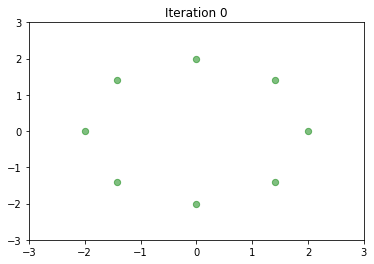

0.00013473456783685833 6.729590677423403e-05 9.60801887512207
tensor(4017.6953, device='cuda:0') tensor(4017.6763, device='cuda:0')
tensor(4017.7168, device='cuda:0') tensor(4017.6987, device='cuda:0')
tensor(4017.7400, device='cuda:0') tensor(4017.7214, device='cuda:0')
tensor(4017.7622, device='cuda:0') tensor(4017.7437, device='cuda:0')
tensor(4017.7844, device='cuda:0') tensor(4017.7659, device='cuda:0')
tensor(4017.8064, device='cuda:0') tensor(4017.7878, device='cuda:0')
tensor(4017.8284, device='cuda:0') tensor(4017.8103, device='cuda:0')
tensor(4017.8496, device='cuda:0') tensor(4017.8313, device='cuda:0')
tensor(4017.8718, device='cuda:0') tensor(4017.8533, device='cuda:0')
tensor(4017.8931, device='cuda:0') tensor(4017.8755, device='cuda:0')
tensor(4017.9136, device='cuda:0') tensor(4017.8962, device='cuda:0')
tensor(4017.9358, device='cuda:0') tensor(4017.9175, device='cuda:0')
tensor(4017.9573, device='cuda:0') tensor(4017.9390, device='cuda:0')
tensor(4017.9780, device='cu

tensor(4019.9539, device='cuda:0') tensor(4019.9409, device='cuda:0')
tensor(4019.9688, device='cuda:0') tensor(4019.9561, device='cuda:0')
tensor(4019.9839, device='cuda:0') tensor(4019.9709, device='cuda:0')
tensor(4019.9983, device='cuda:0') tensor(4019.9863, device='cuda:0')
tensor(4020.0134, device='cuda:0') tensor(4020.0010, device='cuda:0')
tensor(4020.0293, device='cuda:0') tensor(4020.0164, device='cuda:0')
tensor(4020.0435, device='cuda:0') tensor(4020.0315, device='cuda:0')
tensor(4020.0583, device='cuda:0') tensor(4020.0466, device='cuda:0')
tensor(4020.0730, device='cuda:0') tensor(4020.0610, device='cuda:0')
tensor(4020.0881, device='cuda:0') tensor(4020.0757, device='cuda:0')
tensor(4020.1023, device='cuda:0') tensor(4020.0906, device='cuda:0')
tensor(4020.1167, device='cuda:0') tensor(4020.1045, device='cuda:0')
tensor(4020.1311, device='cuda:0') tensor(4020.1194, device='cuda:0')
tensor(4020.1462, device='cuda:0') tensor(4020.1335, device='cuda:0')
tensor(4020.1611, de

tensor(4021.8943, device='cuda:0') tensor(4021.8821, device='cuda:0')
tensor(4021.9084, device='cuda:0') tensor(4021.8965, device='cuda:0')
tensor(4021.9236, device='cuda:0') tensor(4021.9111, device='cuda:0')
tensor(4021.9380, device='cuda:0') tensor(4021.9263, device='cuda:0')
tensor(4021.9521, device='cuda:0') tensor(4021.9407, device='cuda:0')
tensor(4021.9663, device='cuda:0') tensor(4021.9546, device='cuda:0')
tensor(4021.9810, device='cuda:0') tensor(4021.9692, device='cuda:0')
tensor(4021.9944, device='cuda:0') tensor(4021.9832, device='cuda:0')
tensor(4022.0088, device='cuda:0') tensor(4021.9973, device='cuda:0')
tensor(4022.0222, device='cuda:0') tensor(4022.0107, device='cuda:0')
tensor(4022.0356, device='cuda:0') tensor(4022.0242, device='cuda:0')
tensor(4022.0493, device='cuda:0') tensor(4022.0376, device='cuda:0')
tensor(4022.0664, device='cuda:0') tensor(4022.0520, device='cuda:0')
tensor(4022.0854, device='cuda:0') tensor(4022.0706, device='cuda:0')
tensor(4022.1057, de

tensor(4024.2629, device='cuda:0') tensor(4024.2466, device='cuda:0')
tensor(4024.2817, device='cuda:0') tensor(4024.2666, device='cuda:0')
tensor(4024.3003, device='cuda:0') tensor(4024.2849, device='cuda:0')
tensor(4024.3198, device='cuda:0') tensor(4024.3040, device='cuda:0')
tensor(4024.3401, device='cuda:0') tensor(4024.3230, device='cuda:0')
tensor(4024.3594, device='cuda:0') tensor(4024.3435, device='cuda:0')
tensor(4024.3779, device='cuda:0') tensor(4024.3628, device='cuda:0')
tensor(4024.3975, device='cuda:0') tensor(4024.3818, device='cuda:0')
tensor(4024.4185, device='cuda:0') tensor(4024.4009, device='cuda:0')
tensor(4024.4377, device='cuda:0') tensor(4024.4216, device='cuda:0')
tensor(4024.4575, device='cuda:0') tensor(4024.4414, device='cuda:0')
tensor(4024.4778, device='cuda:0') tensor(4024.4604, device='cuda:0')
tensor(4024.4971, device='cuda:0') tensor(4024.4805, device='cuda:0')
tensor(4024.5168, device='cuda:0') tensor(4024.5000, device='cuda:0')
tensor(4024.5369, de

tensor(4025.6687, device='cuda:0') tensor(4025.6465, device='cuda:0')
tensor(4025.6987, device='cuda:0') tensor(4025.6741, device='cuda:0')
tensor(4025.7246, device='cuda:0') tensor(4025.7034, device='cuda:0')
tensor(4025.7537, device='cuda:0') tensor(4025.7295, device='cuda:0')
tensor(4025.7791, device='cuda:0') tensor(4025.7576, device='cuda:0')
tensor(4025.8013, device='cuda:0') tensor(4025.7834, device='cuda:0')
tensor(4025.8232, device='cuda:0') tensor(4025.8044, device='cuda:0')
tensor(4025.8501, device='cuda:0') tensor(4025.8274, device='cuda:0')
tensor(4025.8745, device='cuda:0') tensor(4025.8542, device='cuda:0')
tensor(4025.8989, device='cuda:0') tensor(4025.8787, device='cuda:0')
tensor(4025.9248, device='cuda:0') tensor(4025.9041, device='cuda:0')
tensor(4025.9482, device='cuda:0') tensor(4025.9285, device='cuda:0')
tensor(4025.9675, device='cuda:0') tensor(4025.9512, device='cuda:0')
tensor(4025.9927, device='cuda:0') tensor(4025.9709, device='cuda:0')
tensor(4026.0183, de

tensor(4028.2422, device='cuda:0') tensor(4028.2263, device='cuda:0')
tensor(4028.2600, device='cuda:0') tensor(4028.2451, device='cuda:0')
tensor(4028.2776, device='cuda:0') tensor(4028.2627, device='cuda:0')
tensor(4028.2947, device='cuda:0') tensor(4028.2803, device='cuda:0')
tensor(4028.3132, device='cuda:0') tensor(4028.2988, device='cuda:0')
tensor(4028.3311, device='cuda:0') tensor(4028.3162, device='cuda:0')
tensor(4028.3484, device='cuda:0') tensor(4028.3340, device='cuda:0')
tensor(4028.3660, device='cuda:0') tensor(4028.3513, device='cuda:0')
tensor(4028.3831, device='cuda:0') tensor(4028.3687, device='cuda:0')
tensor(4028.4009, device='cuda:0') tensor(4028.3855, device='cuda:0')
tensor(4028.4182, device='cuda:0') tensor(4028.4033, device='cuda:0')
tensor(4028.4351, device='cuda:0') tensor(4028.4211, device='cuda:0')
tensor(4028.4531, device='cuda:0') tensor(4028.4385, device='cuda:0')
tensor(4028.4695, device='cuda:0') tensor(4028.4561, device='cuda:0')
tensor(4028.4871, de

tensor(4030.1140, device='cuda:0') tensor(4030.0981, device='cuda:0')
tensor(4030.1326, device='cuda:0') tensor(4030.1169, device='cuda:0')
tensor(4030.1531, device='cuda:0') tensor(4030.1360, device='cuda:0')
tensor(4030.1721, device='cuda:0') tensor(4030.1565, device='cuda:0')
tensor(4030.1924, device='cuda:0') tensor(4030.1760, device='cuda:0')
tensor(4030.2131, device='cuda:0') tensor(4030.1953, device='cuda:0')
tensor(4030.2349, device='cuda:0') tensor(4030.2163, device='cuda:0')
tensor(4030.2554, device='cuda:0') tensor(4030.2383, device='cuda:0')
tensor(4030.2742, device='cuda:0') tensor(4030.2583, device='cuda:0')
tensor(4030.2937, device='cuda:0') tensor(4030.2771, device='cuda:0')
tensor(4030.3132, device='cuda:0') tensor(4030.2969, device='cuda:0')
tensor(4030.3330, device='cuda:0') tensor(4030.3159, device='cuda:0')
tensor(4030.3516, device='cuda:0') tensor(4030.3362, device='cuda:0')
tensor(4030.3721, device='cuda:0') tensor(4030.3552, device='cuda:0')
tensor(4030.3921, de

tensor(4031.5884, device='cuda:0') tensor(4031.6316, device='cuda:0')
tensor(4031.5598, device='cuda:0') tensor(4031.5796, device='cuda:0')
tensor(4031.5623, device='cuda:0') tensor(4031.5579, device='cuda:0')
tensor(4031.5962, device='cuda:0') tensor(4031.5676, device='cuda:0')
tensor(4031.6384, device='cuda:0') tensor(4031.6028, device='cuda:0')
tensor(4031.6882, device='cuda:0') tensor(4031.6484, device='cuda:0')
tensor(4031.7341, device='cuda:0') tensor(4031.6956, device='cuda:0')
tensor(4031.7773, device='cuda:0') tensor(4031.7402, device='cuda:0')
tensor(4031.8193, device='cuda:0') tensor(4031.7844, device='cuda:0')
tensor(4031.8665, device='cuda:0') tensor(4031.8276, device='cuda:0')
tensor(4031.9097, device='cuda:0') tensor(4031.8740, device='cuda:0')
tensor(4031.9502, device='cuda:0') tensor(4031.9165, device='cuda:0')
tensor(4031.9885, device='cuda:0') tensor(4031.9565, device='cuda:0')
tensor(4032.0251, device='cuda:0') tensor(4031.9937, device='cuda:0')
tensor(4032.0627, de

tensor(4034.9324, device='cuda:0') tensor(4034.9143, device='cuda:0')
tensor(4034.9536, device='cuda:0') tensor(4034.9358, device='cuda:0')
tensor(4034.9751, device='cuda:0') tensor(4034.9573, device='cuda:0')
tensor(4034.9976, device='cuda:0') tensor(4034.9792, device='cuda:0')
tensor(4035.0195, device='cuda:0') tensor(4035.0015, device='cuda:0')
tensor(4035.0405, device='cuda:0') tensor(4035.0234, device='cuda:0')
tensor(4035.0613, device='cuda:0') tensor(4035.0437, device='cuda:0')
tensor(4035.0820, device='cuda:0') tensor(4035.0652, device='cuda:0')
tensor(4035.1018, device='cuda:0') tensor(4035.0847, device='cuda:0')
tensor(4035.1223, device='cuda:0') tensor(4035.1050, device='cuda:0')
tensor(4035.1418, device='cuda:0') tensor(4035.1250, device='cuda:0')
tensor(4035.1611, device='cuda:0') tensor(4035.1445, device='cuda:0')
tensor(4035.1816, device='cuda:0') tensor(4035.1646, device='cuda:0')
tensor(4035.2024, device='cuda:0') tensor(4035.1846, device='cuda:0')
tensor(4035.2209, de

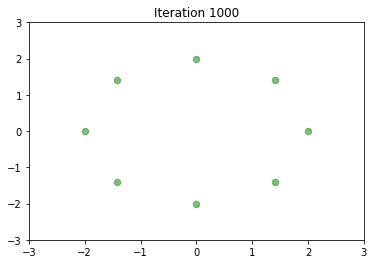

1.6523559679626487e-05 8.106264431262389e-06 11.724813461303711
tensor(4035.3538, device='cuda:0') tensor(4035.3389, device='cuda:0')
tensor(4035.3723, device='cuda:0') tensor(4035.3572, device='cuda:0')
tensor(4035.3911, device='cuda:0') tensor(4035.3755, device='cuda:0')
tensor(4035.4106, device='cuda:0') tensor(4035.3948, device='cuda:0')
tensor(4035.4287, device='cuda:0') tensor(4035.4136, device='cuda:0')
tensor(4035.4458, device='cuda:0') tensor(4035.4309, device='cuda:0')
tensor(4035.4644, device='cuda:0') tensor(4035.4490, device='cuda:0')
tensor(4035.4814, device='cuda:0') tensor(4035.4673, device='cuda:0')
tensor(4035.4983, device='cuda:0') tensor(4035.4846, device='cuda:0')
tensor(4035.5149, device='cuda:0') tensor(4035.5017, device='cuda:0')
tensor(4035.5327, device='cuda:0') tensor(4035.5176, device='cuda:0')
tensor(4035.5496, device='cuda:0') tensor(4035.5349, device='cuda:0')
tensor(4035.5664, device='cuda:0') tensor(4035.5530, device='cuda:0')
tensor(4035.5820, device='

tensor(4037.0322, device='cuda:0') tensor(4037.0137, device='cuda:0')
tensor(4037.0576, device='cuda:0') tensor(4037.0361, device='cuda:0')
tensor(4037.0830, device='cuda:0') tensor(4037.0615, device='cuda:0')
tensor(4037.1099, device='cuda:0') tensor(4037.0876, device='cuda:0')
tensor(4037.1362, device='cuda:0') tensor(4037.1143, device='cuda:0')
tensor(4037.1606, device='cuda:0') tensor(4037.1411, device='cuda:0')
tensor(4037.1868, device='cuda:0') tensor(4037.1648, device='cuda:0')
tensor(4037.2134, device='cuda:0') tensor(4037.1907, device='cuda:0')
tensor(4037.2354, device='cuda:0') tensor(4037.2168, device='cuda:0')
tensor(4037.2615, device='cuda:0') tensor(4037.2397, device='cuda:0')
tensor(4037.2869, device='cuda:0') tensor(4037.2654, device='cuda:0')
tensor(4037.3115, device='cuda:0') tensor(4037.2913, device='cuda:0')
tensor(4037.3379, device='cuda:0') tensor(4037.3157, device='cuda:0')
tensor(4037.3616, device='cuda:0') tensor(4037.3423, device='cuda:0')
tensor(4037.3870, de

tensor(4040.0503, device='cuda:0') tensor(4040.0293, device='cuda:0')
tensor(4040.0754, device='cuda:0') tensor(4040.0544, device='cuda:0')
tensor(4040.1011, device='cuda:0') tensor(4040.0796, device='cuda:0')
tensor(4040.1262, device='cuda:0') tensor(4040.1045, device='cuda:0')
tensor(4040.1506, device='cuda:0') tensor(4040.1306, device='cuda:0')
tensor(4040.1758, device='cuda:0') tensor(4040.1548, device='cuda:0')
tensor(4040.2017, device='cuda:0') tensor(4040.1797, device='cuda:0')
tensor(4040.2271, device='cuda:0') tensor(4040.2063, device='cuda:0')
tensor(4040.2527, device='cuda:0') tensor(4040.2314, device='cuda:0')
tensor(4040.2798, device='cuda:0') tensor(4040.2571, device='cuda:0')
tensor(4040.3052, device='cuda:0') tensor(4040.2837, device='cuda:0')
tensor(4040.3313, device='cuda:0') tensor(4040.3098, device='cuda:0')
tensor(4040.3569, device='cuda:0') tensor(4040.3347, device='cuda:0')
tensor(4040.3835, device='cuda:0') tensor(4040.3618, device='cuda:0')
tensor(4040.4094, de

tensor(4043.3406, device='cuda:0') tensor(4043.3196, device='cuda:0')
tensor(4043.3667, device='cuda:0') tensor(4043.3450, device='cuda:0')
tensor(4043.3923, device='cuda:0') tensor(4043.3713, device='cuda:0')
tensor(4043.4177, device='cuda:0') tensor(4043.3960, device='cuda:0')
tensor(4043.4438, device='cuda:0') tensor(4043.4219, device='cuda:0')
tensor(4043.4692, device='cuda:0') tensor(4043.4478, device='cuda:0')
tensor(4043.4949, device='cuda:0') tensor(4043.4731, device='cuda:0')
tensor(4043.5200, device='cuda:0') tensor(4043.4993, device='cuda:0')
tensor(4043.5449, device='cuda:0') tensor(4043.5239, device='cuda:0')
tensor(4043.5708, device='cuda:0') tensor(4043.5491, device='cuda:0')
tensor(4043.5955, device='cuda:0') tensor(4043.5750, device='cuda:0')
tensor(4043.6204, device='cuda:0') tensor(4043.5996, device='cuda:0')
tensor(4043.6458, device='cuda:0') tensor(4043.6250, device='cuda:0')
tensor(4043.6709, device='cuda:0') tensor(4043.6501, device='cuda:0')
tensor(4043.6953, de

tensor(4046.4292, device='cuda:0') tensor(4046.4104, device='cuda:0')
tensor(4046.4526, device='cuda:0') tensor(4046.4331, device='cuda:0')
tensor(4046.4749, device='cuda:0') tensor(4046.4558, device='cuda:0')
tensor(4046.4985, device='cuda:0') tensor(4046.4792, device='cuda:0')
tensor(4046.5217, device='cuda:0') tensor(4046.5024, device='cuda:0')
tensor(4046.5444, device='cuda:0') tensor(4046.5256, device='cuda:0')
tensor(4046.5676, device='cuda:0') tensor(4046.5483, device='cuda:0')
tensor(4046.5896, device='cuda:0') tensor(4046.5715, device='cuda:0')
tensor(4046.6133, device='cuda:0') tensor(4046.5938, device='cuda:0')
tensor(4046.6360, device='cuda:0') tensor(4046.6167, device='cuda:0')
tensor(4046.6597, device='cuda:0') tensor(4046.6399, device='cuda:0')
tensor(4046.6824, device='cuda:0') tensor(4046.6636, device='cuda:0')
tensor(4046.7061, device='cuda:0') tensor(4046.6858, device='cuda:0')
tensor(4046.7295, device='cuda:0') tensor(4046.7102, device='cuda:0')
tensor(4046.7512, de

KeyboardInterrupt: 

In [38]:
for it in tqdm_notebook(range(num_iterations)):
    d_infos = []
    for d_index in range(d_steps):
        d_info = d_loop()
        d_infos.append(d_info)
    d_infos = np.mean(d_infos, 0)
    d_real_loss, d_fake_loss = d_infos
    
    g_infos = []
    for g_index in range(g_steps):
        g_info = g_loop()
        g_infos.append(g_info)
    g_infos = np.mean(g_infos)
    g_loss = g_infos
    
    if it % log_interval == 0:
        g_fake_data = g_sample()
        plot(g_fake_data, title='Iteration {}'.format(it))
        print(d_real_loss, d_fake_loss, g_loss)